# Import

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors

import torch
from torch import FloatTensor, LongTensor
import math

In [2]:
from load_script_deep_framework import load_dataset

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
'Dataset plotting function'
def plot_output(train, all_output, permutation):
    plt.figure(figsize=(3,3))
    plt.scatter(train[permutation][:,0], train[permutation][:,1], c = all_output)

# Loading the dataset

In [5]:
train,target_train = load_dataset()

In [6]:
test,target_test = load_dataset()

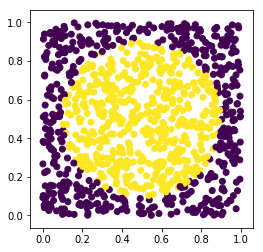

In [7]:
plt.figure(figsize=(4,4))
plt.scatter(test[:,0], test[:,1], c=target_test[:,1].numpy())
plt.show()

# Generic Module Class

In [8]:
class Module():
    '''General class structure from which to inherit'''
    def forward(self,input):
        raise NotImplemented
        
    def backward(self,input):
        raise NotImplemented
            
    def param(self):
        return []
    
    def __call__(self, *input):
        return self.forward(*input)

    
    def zero_grad_(self):
        return
    
    def update_weights_(self, learning_rate):
        return

# Specific classes

In [9]:
class Linear(Module):
    '''Linear layer implementation, needs the number of inputs and number of units to call an instance.
    It initializes Gaussian weights with mean = 0 and std = 0.1.
    Bias terms are included in the weights matrix.'''
    def __init__(self, input_dimension, output_dimension):
        super(Linear,self).__init__()
        
        self._input_dimension = input_dimension
        self._output_dimension = output_dimension
    
        self._weights = torch.randn(self._output_dimension, self._input_dimension + 1)*1e-1

        self._gradient = torch.zeros(self._weights.shape)
    
    def forward(self, input):
        
        # Append '1' to input to be multiplied to bias term
        self._input = input.view(-1, self._input_dimension)
        self._batch_size = self._input.shape[0]
        self._input = torch.cat((self._input, torch.Tensor(self._input.shape[0]).fill_(1)), dim=1)
        self._output = self._input.mm(self._weights.t())
        
        return self._output.clone()
        
    def backward(self, d_dy):
        self._gradient.add_(d_dy.t().mm(self._input))
        
        # Narrowing is done to exclude bias terms in backprop.
        d_dx = d_dy.mm(self._weights.narrow(1, 0, self._input_dimension))
        
        return d_dx
    
    def param(self):
        return [self._weights, self._gradient]
    

    def zero_grad_(self):
        self._gradient.zero_()
        
    def update_weights_(self, learning_rate):
        self._weights.add_(- learning_rate * self._gradient)

In [10]:
class ReLU(Module):
    '''ReLU activation function class, it performs backward and forward pass.'''
    def __init__(self):
        super(ReLU,self).__init__()
        
    def forward(self,input):
        self._input = input.clone()
        
        self._output = self._input.clone()
        self._output[self._output < 0] = 0

        return self._output.clone()
    
    def backward(self,d_dy):
        d_dx = d_dy.clone()
        d_dx[self._input < 0] = 0
        
        return d_dx
        

In [11]:
class Tanh(Module):
    '''Tanh activation function class, it performs backward and forward pass.'''
    def __init__(self):
        super(Tanh,self).__init__()
        
    def forward(self,input):
        self._input = input.clone()
        
        self._output = self._input.tanh()
        
        return self._output.clone()
    
    def backward(self,d_dy):
        d_dx= (1 - self._input.tanh()**2).mul(d_dy)
        
        return d_dx
        

In [12]:
class LossMSE(Module):
    def __init__(self):
        super(LossMSE,self).__init__()
        
    def forward(self, input, target):
        '''Returns square error between input and target.'''
        self._input = input - target
        self._output = (self._input).pow(2).sum()
        return self._output
        
    def backward(self):
        d_dy = 2 * self._input
        return d_dy

In [13]:
class OptimSGD():
    def __init__(self,sequential, learning_rate, decay_rate=1):
        super(OptimSGD,self).__init__()
        
        self._learning_rate = learning_rate
        self._sequential= sequential
        self._decay_rate = decay_rate
    
    def step(self):
        '''Computes an update step. Each parameter is a tuple if (parameter, gradient)'''
        for param in self._sequential.param():
            if param:
                param[0].add_(- self._learning_rate * param[1]) 
        
    def zero_grad_(self):
        for param_grad in self._sequential.param():
            if param_grad:
                param_grad[1].zero_()
        
    def learning_rate_decay_step(self):
        self._learning_rate *= self._decay_rate
        
        

In [14]:
class Sequential(Module):
    '''Builds a neural network, takes a list of layers and activation functions + loss function when instantiated.
    Performs the forward pass for the input through all the layers and returns loss.
    Similarly performs backward pass.'''
    
    def __init__(self, modules ,loss):
        super(Sequential,self).__init__()
        
        self._modules = modules
        self._loss = loss
    
    def forward(self, input, target):
        
        y = input.clone()
        for module in self._modules:
            y = module(y)
        
        output = y.clone()
        
        loss = self._loss(y, target)
        
        return loss, output
    
    def backward(self):
        d_dy = self._loss.backward()
        
        for module in reversed(self._modules):
            d_dy = module.backward(d_dy)
    
    def param(self):
        
        param_list=[]
        
        for module in self._modules:
            if module.param():
                param_list.append(module.param())
                
        return param_list


    def zero_grad_(self):
        for module in self._modules:
            module.zero_grad_()

    def update_weights_(self,learning_rate):
        for module in self._modules:
            module.update_weights_(learning_rate)

In [16]:
def test_error():

    correct_test = 0

    # Forward pass
    loss, output = network(test, target_test)

    boolean_target = target_test[:,1] > target_test[:,0]
    boolean_output = output[:,1] > output[:,0]

    correct_test += sum(boolean_output == boolean_target)

    correct_test = (1000-correct_test)/1000 * 100
    print('Test error {} %'.format(correct_test))

    return correct_test

Epoch: 0. Train error: 48.5 %. Loss: 2.0813178803026675.
Test error 50.2 %
Epoch: 1. Train error: 51.1 %. Loss: 2.112014748245478.
Test error 50.2 %
Epoch: 2. Train error: 49.6 %. Loss: 2.086457544609904.
Test error 49.8 %
Epoch: 3. Train error: 48.1 %. Loss: 2.081094060406089.
Test error 50.2 %
Epoch: 4. Train error: 49.8 %. Loss: 2.081011160843074.
Test error 45.1 %
Epoch: 5. Train error: 48.199999999999996 %. Loss: 2.048275457575322.
Test error 44.5 %
Epoch: 6. Train error: 40.5 %. Loss: 1.9341664169551753.
Test error 46.5 %
Epoch: 7. Train error: 38.0 %. Loss: 1.8554530844248818.
Test error 28.799999999999997 %
Epoch: 8. Train error: 31.2 %. Loss: 1.6880952469156765.
Test error 33.5 %
Epoch: 9. Train error: 28.799999999999997 %. Loss: 1.5498003912917528.
Test error 35.0 %
Epoch: 10. Train error: 21.099999999999998 %. Loss: 1.228427550966804.
Test error 18.099999999999998 %
Epoch: 11. Train error: 20.3 %. Loss: 1.1195579739002646.
Test error 15.5 %
Epoch: 12. Train error: 16.2 %. Lo

Epoch: 101. Train error: 0.3 %. Loss: 0.025730484527651025.
Test error 2.5 %
Epoch: 102. Train error: 0.5 %. Loss: 0.025226603866129082.
Test error 2.1999999999999997 %
Epoch: 103. Train error: 0.3 %. Loss: 0.023523704642699362.
Test error 2.1 %
Epoch: 104. Train error: 0.3 %. Loss: 0.023083935530173467.
Test error 2.1999999999999997 %
Epoch: 105. Train error: 0.2 %. Loss: 0.021167733759627393.
Test error 2.4 %
Epoch: 106. Train error: 0.2 %. Loss: 0.02049827455481727.
Test error 2.1999999999999997 %
Epoch: 107. Train error: 0.3 %. Loss: 0.022048291544349872.
Test error 2.3 %
Epoch: 108. Train error: 0.3 %. Loss: 0.020598253638958598.
Test error 2.1999999999999997 %
Epoch: 109. Train error: 0.2 %. Loss: 0.01937830884666568.
Test error 2.4 %
Epoch: 110. Train error: 0.3 %. Loss: 0.02055828312401474.
Test error 2.1999999999999997 %
Epoch: 111. Train error: 0.3 %. Loss: 0.02050480126064823.
Test error 2.1 %
Epoch: 112. Train error: 0.3 %. Loss: 0.019705900650043687.
Test error 2.199999999

Epoch: 193. Train error: 0.2 %. Loss: 0.01516379855854683.
Test error 2.1999999999999997 %
Epoch: 194. Train error: 0.2 %. Loss: 0.015160765698200776.
Test error 2.1999999999999997 %
Epoch: 195. Train error: 0.2 %. Loss: 0.015157501446545367.
Test error 2.1999999999999997 %
Epoch: 196. Train error: 0.2 %. Loss: 0.015153475999831934.
Test error 2.1999999999999997 %
Epoch: 197. Train error: 0.2 %. Loss: 0.015152974780458652.
Test error 2.1999999999999997 %
Epoch: 198. Train error: 0.2 %. Loss: 0.01514760783987465.
Test error 2.1999999999999997 %
Epoch: 199. Train error: 0.2 %. Loss: 0.015145754479798228.
Test error 2.1999999999999997 %


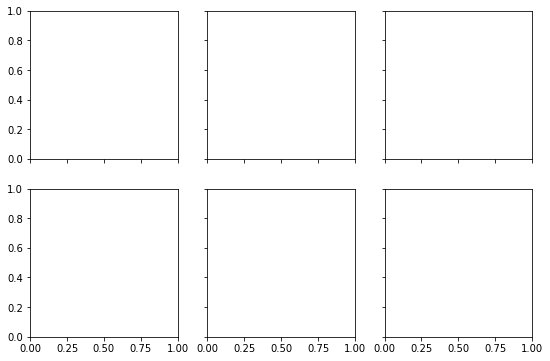

In [27]:
# Define the Neural Network
layers = [
    Linear(2,25),
    ReLU(),
    Linear(25,25),
    ReLU(),
    Linear(25,25),
    ReLU(),
    Linear(25,2),
    Tanh()
]
loss_function = LossMSE()
network = Sequential(layers, loss_function)

# Initial learning rate and decay rate
learning_rate = 5e-2
decay_rate =0.95

optimizer=OptimSGD(network, learning_rate, decay_rate)

num_epochs = 200
mini_batch_size = 4

# Initialize lists to store training loss and test accuracy
train_loss = []
test_correct = []

# Define subplot for dataset visualization
fig, axes = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True, figsize = (9, 6))
ind = 0

for epoch in range(num_epochs):
    
    correct = 0
    all_output = []
    loss_sum = 0
    
    # Randomize order for SGD
    permutation = torch.randperm(target_train.shape[0])
    
    train_batched = [train[permutation][i:(i+mini_batch_size),:] for i in range(train.shape[0]) if i % mini_batch_size == 0]
    target_batched = [target_train[permutation][i:(i+mini_batch_size),:] for i in range(train.shape[0]) if i % mini_batch_size == 0]
    
    for j, batch in enumerate(zip(train_batched, target_batched)):
        
        # Load sample
        train_element, target_element = batch
        
        # Forward pass
        loss, output = network(train_element, target_element)
        loss_sum += loss

        # Backward pass, gradient step and reinitalize gradient
        network.backward()
        #network.update_weights_(learning_rate)
        optimizer.step()
        optimizer.zero_grad_()

        # Training error
        boolean_target = target_element[:,1] > target_element[:,0]
        boolean_output = output[:,1] > output[:,0]
        
        all_output.append(output.numpy().tolist()[1])
        
        correct += sum(boolean_output == boolean_target)
        
    train_loss.append(loss_sum/1000)
    optimizer.learning_rate_decay_step()
    
    if epoch % 1 == 0:
        print('Epoch: {}. Train error: {} %. Loss: {}.'.format(epoch ,(1000-correct)/1000*100, loss_sum/1000))
        
        test_correct.append(test_error())
        
    if epoch in [1, 10, 15, 25, 100, 499] and 0:
        axes[ind // 3, ind % 3].scatter(train[permutation][:,0], train[permutation][:,1], c = all_output)
        ind += 1

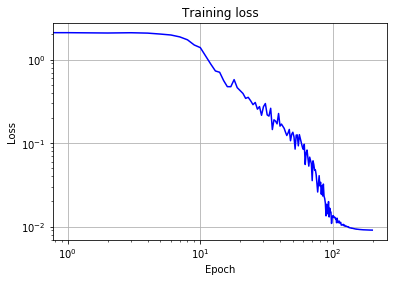

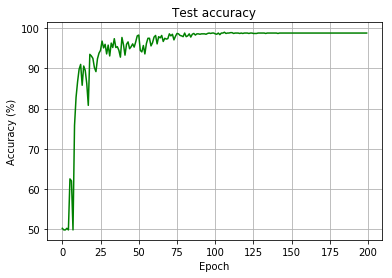

In [19]:
plt.figure("Train Loss")
plt.title("Training loss")
plt.loglog(train_loss, 'b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()
#plt.savefig("figures/loss_loglog.eps", format="eps")

plt.figure("Test accuracy")
plt.title("Test accuracy")
plt.plot([100-i for i in test_correct], 'green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()
#plt.savefig("figures/accuracy.eps", format="eps")

# Test